###  <span style="color:red">**This Notebook can be run from Google Colab:**</span>

https://colab.research.google.com

# **<span style="color:red">Background and motivation:</span>**

#### First, we trained a model using positive patches only (only patches actually containing regions corresponding to growing bacterial colonies in the petri-dish), to specifically differentiate among the 8 bacterial species in our dataset. From the confusion matrix of that model, we could see that the model is having difficulty to differentiate between classes 'C1' and 'C2-3' and between classes 'C4-7' and 'C5'.<br>

#### As a next step, we then trained a model to specifically learn to differentiate 'C1' vs 'C2-3' vs 'all_other' classes. This is a model with 3 classes only.<br>

#### Similarly, we also trained a model to specifically learn to differentiate 'C4-7' vs 'C5' vs 'all_other' classes.<br>

#### Last model we trained was a model to specifically differentiate between positive bacterial colony patches (of any class) and negative patches (either petri-dish background, petri-dish border or white image background). For this,we just combined all positive patches (regardless of the bacterial species) in a single 'positive' class and all negative patches in a single 'negative' class.<br> 

#### We then had 4 models, the first one producing 8 predicted probabilities (one for each baterial species), the second one producing 3 predicted probabilities ('C1','C2-3','all_other'), the third one also producing 3 predicted probabilities ('C4-7','C5','all_other') and the fourth one producing 2 predicted probabilities (positive_patch, negative_patch), for a total of 16 predicted probabilities.<br>

#### With those 4 models, using an augmented validation dataset with 9 classes (8 bacterial species + negative_patches), we combined the 16 predicted probabilities as features and y_true, into a training dataset.<br>

#### On this notebook, we now intend to use to train a simple SVM or other simple classification model, to learn to predict either negative or the correct bacterial species, from the probabilities produced by the 4 models above.

In [0]:
import os
import urllib.request
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import pickle

from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV

from google.colab import drive
drive.mount('/content/gdrive')

import warnings
warnings.simplefilter("ignore")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## **Let's download the prevously produced training data:**

In [0]:
print('Downloading train_data.csv...')
url = 'https://capstone-fs7.s3.amazonaws.com/train_data_2.csv'
urllib.request.urlretrieve(url, 'train_data.csv')
print('train_data.csv sucessfully downloaded in root dir.')
print('Root dir content: {}'.format(os.listdir()))

train_data.csv sucessfully downloaded in root dir.
Root dir content: ['.config', 'gdrive', 'train_data.csv', 'sample_data']


### **Let's load the donwnloaded csv into a pandas dataframe:**

In [0]:
column_names = [i for i in range(16)] + ['y']
train_df = pd.read_csv('train_data.csv', names = column_names)
print(train_df)

              0         1         2  ...        14        15    y
0      0.996569  0.000586  0.000304  ...  0.005766  0.994234  0.0
1      0.983230  0.002439  0.001683  ...  0.013915  0.986085  0.0
2      0.993891  0.001264  0.000659  ...  0.007329  0.992671  0.0
3      0.997458  0.000411  0.000263  ...  0.045203  0.954797  0.0
4      0.992007  0.002074  0.000842  ...  0.007682  0.992318  0.0
...         ...       ...       ...  ...       ...       ...  ...
62898  0.484131  0.066657  0.045402  ...  0.994646  0.005353  8.0
62899  0.997091  0.000507  0.000303  ...  0.994020  0.005980  8.0
62900  0.998442  0.000199  0.000134  ...  0.994883  0.005117  8.0
62901  0.997829  0.000386  0.000201  ...  0.993570  0.006430  8.0
62902  0.998135  0.000341  0.000175  ...  0.994937  0.005063  8.0

[62903 rows x 17 columns]


In [0]:
train_df.y.unique()

array([0., 1., 2., 3., 4., 5., 6., 7., 8.])

### **Let's create training data (X) and target value (y):**

In [0]:
train_df = train_df.sample(frac=1, random_state=0) # shuffle the data
X, y = train_df.drop(columns='y'), train_df['y']
print(X.shape, y.shape)

(62903, 16) (62903,)


### **Let's create a smaller train set for development (X_dev, y_dev):**

In [0]:
train_dev_df = train_df.sample(frac=0.1, random_state=0) # ramdomly select 10% of data for development
X_dev, y_dev = train_dev_df.drop(columns='y'), train_dev_df['y']
print(X_dev.shape, y_dev.shape)

(6290, 16) (6290,)


### **Let's quickly compare kernel SVM vs LinearSVM vs LogisticREgression, with default parameters:**

In [0]:
scaled_svc = make_pipeline(StandardScaler(), SVC())
print('\nScore SVC (non-scaled):', np.mean(cross_val_score(SVC(), X_dev, y_dev, cv=5)))
print('Score Scaled SVC:', np.mean(cross_val_score(scaled_svc, X_dev, y_dev, cv=5)))

scaled_LR = make_pipeline(StandardScaler(), LogisticRegression())
print('\nScore Logistic Regression (non-scaled):', np.mean(cross_val_score(LogisticRegression(), X_dev, y_dev, cv=5)))
print('Score Scaled Logistic Regression:', np.mean(cross_val_score(scaled_LR, X_dev, y_dev, cv=5)))

scaled_LinearSVC = make_pipeline(StandardScaler(), LinearSVC())
print('\nScore LinearSVC (non-scaled):', np.mean(cross_val_score(LinearSVC(), X_dev, y_dev, cv=5)))
print('Score Scaled LinearSVC:', np.mean(cross_val_score(scaled_LinearSVC, X_dev, y_dev, cv=5)))

print('\nScore Random Forest:', np.mean(cross_val_score(RandomForestClassifier(), X_dev, y_dev, cv=5)))


Score SVC (non-scaled): 0.8667641381098763
Score Scaled SVC: 0.8734407967080848

Score Logistic Regression (non-scaled): 0.869623944612399
Score Scaled Logistic Regression: 0.8731233402042502

Score LinearSVC (non-scaled): 0.8737609026264591
Score Scaled LinearSVC: 0.8750325137751831

Score Random Forest: 0.8980957963242027


#### **All 3 models produced same or better results when data was scaled (except RF where we didn't scale the data as RF is scale-invariant)**



### **Let's try tuning the 'C' parameter for logistic regression:**

Best Parameter LR: {'classifier__C': 19144.819761699575}

Best Score LR: 0.8774244833068362



Text(0.5, 1.0, 'Log Regression Scores vs Parameter C')

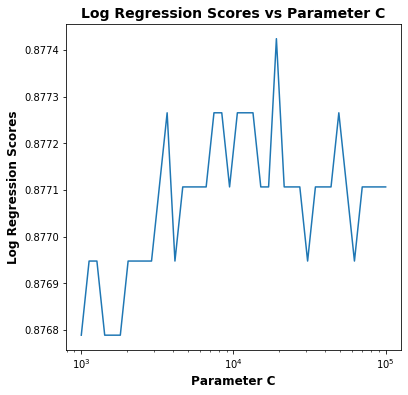

In [0]:
LR_C = np.logspace(3, 5, 40)

# Tune LR parameters using GridSearchCV:
scaled_LR = Pipeline((("preprocess", StandardScaler()),
                      ("classifier", LogisticRegression())))
LR_param_grid = {'classifier__C': LR_C}
scaled_LR_grid = GridSearchCV(scaled_LR, LR_param_grid, cv=5)
scaled_LR_grid.fit(X_dev, y_dev)

print('Best Parameter LR: {}'.format(scaled_LR_grid.best_params_))
print('\nBest Score LR: {}\n'.format(scaled_LR_grid.best_score_))

scaled_LR_scores = scaled_LR_grid.cv_results_['mean_test_score']
plt.figure().set_size_inches(6, 6)
plt.semilogx(LR_C, scaled_LR_scores)
plt.ylabel('Log Regression Scores', fontsize=12, fontweight='bold')
plt.xlabel('Parameter C', fontsize=12, fontweight='bold')
plt.title('Log Regression Scores vs Parameter C', fontsize=14, fontweight='bold')

### **Let's try tuning the 'C' parameter for Linear SVM:**

Best Parameter SVM: {'classifier__C': 9.426684551178854}
Score LinearSVM: 0.8774244833068362



Text(0.5, 1.0, 'LinearSVM Scores vs Parameter C')

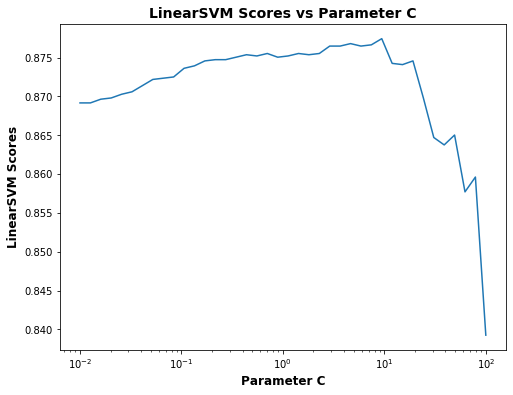

In [0]:
LinearSVM_C = np.logspace(-2, 2, 40)

LinearSVM = Pipeline((("preprocess", StandardScaler()),
                      ("classifier", LinearSVC())))
LinearSVM_param_grid = {'classifier__C': LinearSVM_C}
LinearSVM_grid = GridSearchCV(LinearSVM, LinearSVM_param_grid, cv=5)
LinearSVM_grid.fit(X_dev, y_dev)

print('Best Parameter SVM: {}'.format(LinearSVM_grid.best_params_))
print('Score LinearSVM: {}\n'.format(LinearSVM_grid.best_score_))

LinearSVM_scores = LinearSVM_grid.cv_results_['mean_test_score']
plt.figure().set_size_inches(8, 6)
plt.semilogx(LinearSVM_C, LinearSVM_scores)
plt.ylabel('LinearSVM Scores', fontsize=12, fontweight='bold')
plt.xlabel('Parameter C', fontsize=12, fontweight='bold')
plt.title('LinearSVM Scores vs Parameter C', fontsize=14, fontweight='bold')

### **Let's try tuning the 'C' parameter for kernel SVM:**

Best Parameter SVM: {'classifier__C': 4142.298383054175}
Score SVM: 0.9



Text(0.5, 1.0, 'Kernel SVM Scores vs Parameter C')

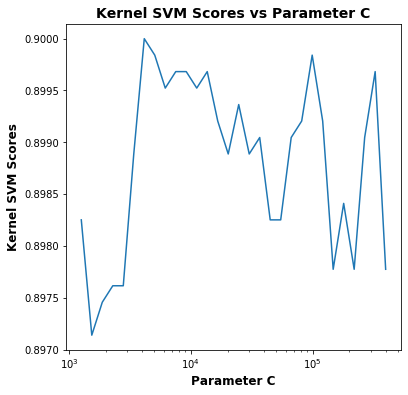

In [0]:
SVM_C = np.logspace(3.1, 5.6, 30)

SVM = Pipeline((("preprocess", StandardScaler()),
                ("classifier", SVC(gamma='scale'))))
SVM_param_grid = {'classifier__C': SVM_C}
SVM_grid = GridSearchCV(SVM, SVM_param_grid, cv=5)
SVM_grid.fit(X_dev, y_dev)

print('Best Parameter SVM: {}'.format(SVM_grid.best_params_))
print('Score SVM: {}\n'.format(SVM_grid.best_score_))

SVM_scores = SVM_grid.cv_results_['mean_test_score']
plt.figure().set_size_inches(6, 6)
plt.semilogx(SVM_C, SVM_scores)
plt.ylabel('Kernel SVM Scores', fontsize=12, fontweight='bold')
plt.xlabel('Parameter C', fontsize=12, fontweight='bold')
plt.title('Kernel SVM Scores vs Parameter C', fontsize=14, fontweight='bold')

### **Let's try tuning the 'max_features' parameter for Random Forest:**

Best Parameter RF: {'max_features': 3}
Score RF: 0.9027027027027027



Text(0.5, 1.0, 'Random Forest Scores vs Parameter max_features')

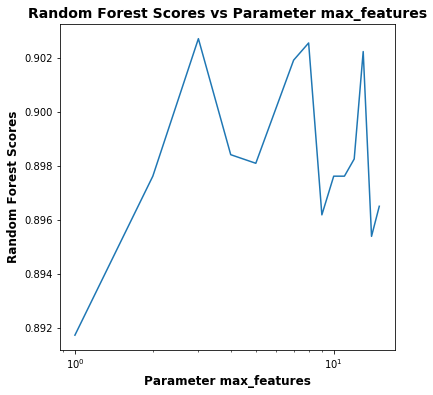

In [0]:
max_features = range(1,16)

RF_param_grid = {'max_features': max_features}

RF_grid = GridSearchCV(RandomForestClassifier(), RF_param_grid, cv = 5)
RF_grid.fit(X_dev, y_dev)

print('Best Parameter RF: {}'.format(RF_grid.best_params_))
print('Score RF: {}\n'.format(RF_grid.best_score_))

RF_scores = RF_grid.cv_results_['mean_test_score']
plt.figure().set_size_inches(6, 6)
plt.semilogx(max_features, RF_scores)
plt.ylabel('Random Forest Scores', fontsize=12, fontweight='bold')
plt.xlabel('Parameter max_features', fontsize=12, fontweight='bold')
plt.title('Random Forest Scores vs Parameter max_features', fontsize=14, fontweight='bold')

### **Let's test the performance of all 4 models on the entire training dataset:**

In [0]:
LR = scaled_LR_grid.best_estimator_
SVM = SVM_grid.best_estimator_
LinearSVM = LinearSVM_grid.best_estimator_
RF = RF_grid.best_estimator_

print("\nScores on the entire training dataset:")

print("\nLR score: {:.4f}".format(LR.score(X, y)))
print("Kernel SVM score: {:.4f}".format(SVM.score(X, y)))
print("LinearSVM score: {:.4f}".format(LinearSVM.score(X, y)))
print("RF score: {:.4f}".format(RF.score(X, y)))


Scores on the entire training dataset:

LR score: 0.8797
Kernel SVM score: 0.9087
LinearSVM score: 0.8776
RF score: 0.9136


#### **We got better results with kernel SVM and Random Forest**

### **Let's now try tunning the 'gamma' parameter on the kernel SVM model to see if we can improve the results and compare:**

Best Parameter SVM: {'classifier__gamma': 0.08858667904100823}
Score SVM: 0.9001589825119237

SVM score on entire training data:
 0.9100



Text(0.5, 1.0, 'SVM Scores vs Parameter gamma')

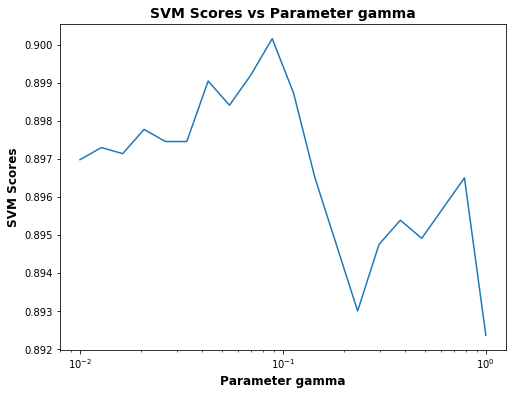

In [0]:
SVM_gamma = np.logspace(-2,0,20)

SVM = Pipeline((("preprocess", StandardScaler()),
                ("classifier", SVC(C=SVM_grid.best_estimator_.get_params('steps')['classifier'].C))))
SVM_param_grid = {'classifier__gamma': SVM_gamma}
SVM_grid = GridSearchCV(SVM, SVM_param_grid, cv=5)
SVM_grid.fit(X_dev, y_dev)

print('Best Parameter SVM: {}'.format(SVM_grid.best_params_))
print('Score SVM: {}\n'.format(SVM_grid.best_score_))

print("SVM score on entire training data:\n {:.4f}\n".format(SVM_grid.best_estimator_.score(X, y)))

SVM_scores = SVM_grid.cv_results_['mean_test_score']
plt.figure().set_size_inches(8, 6)
plt.semilogx(SVM_gamma, SVM_scores)
plt.ylabel('SVM Scores', fontsize=12, fontweight='bold')
plt.xlabel('Parameter gamma', fontsize=12, fontweight='bold')
plt.title('SVM Scores vs Parameter gamma', fontsize=14, fontweight='bold')

### **Let's now try tunning the 'max_leaf_nodes' parameter on the Random Forest model:**

Best Parameter RF: {'max_leaf_nodes': 94266}
Score RF: 0.9052464228934817

RF score on entire training data:
 0.9135



Text(0.5, 1.0, 'Random Forest Scores vs Parameter max_leaf_nodes')

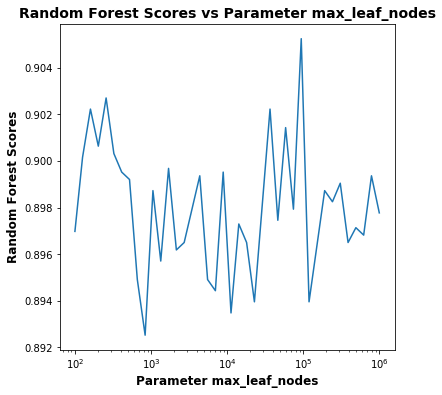

In [0]:
max_leaf_nodes = [int(a) for a in np.logspace(2,6,40)]

RF_param_grid = {'max_leaf_nodes': max_leaf_nodes}

RF_grid = GridSearchCV(RandomForestClassifier(max_features=3,
                                              n_estimators = 10),
                       RF_param_grid, cv = 5)
RF_grid.fit(X_dev, y_dev)

print('Best Parameter RF: {}'.format(RF_grid.best_params_))
print('Score RF: {}\n'.format(RF_grid.best_score_))

print("RF score on entire training data:\n {:.4f}\n".format(RF_grid.best_estimator_.score(X, y)))

RF_scores = RF_grid.cv_results_['mean_test_score']
plt.figure().set_size_inches(6, 6)
plt.semilogx(max_leaf_nodes, RF_scores)
plt.ylabel('Random Forest Scores', fontsize=12, fontweight='bold')
plt.xlabel('Parameter max_leaf_nodes', fontsize=12, fontweight='bold')
plt.title('Random Forest Scores vs Parameter max_leaf_nodes', fontsize=14, fontweight='bold')

#### **We got the best results with Random Forest.**

### **Let's now train a calibrated Random Forest model (calibrated probability outputs) on the entire training dataset then save it to GoogleDrive:**

In [0]:
RF_cal = CalibratedClassifierCV(RF_grid.best_estimator_, method='isotonic')
RF_cal.fit(X, y)
dest = 'gdrive/My Drive/Capstone/combine_model_cal_rf_0.9135.sav'
pickle.dump(RF_cal, open(dest, 'wb'))